In [1]:
import scipy.io
from scipy.integrate import odeint
import math 
import numpy as np
import matplotlib.pyplot as plt
import theano
%matplotlib inline
THEANO_FLAGS='floatX=float32,optimizer=fast_compile'

In [2]:
def model_deriv(y, t, param):
    #Define parameters
    a,b,c=param
    
    #define states
    V,R=y
    #define derivatives
    dV_dt=(V-((V**3)/3) +R)*c
    dR_dt=-(V-a+b*R)/c
    return dV_dt,dR_dt
    
def model_sol(param):
    
    y0 = [-1,1]
    time = np.linspace(0, 20, 200)
    solution = odeint(model_deriv, y0, time, args=(param,))
    return np.array(solution)

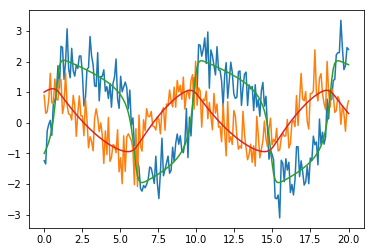

In [6]:
time = np.linspace(0, 20, 200)
sigma=0.5
sol=model_sol([0.2,0.2,3.])
Y=sol+np.random.randn(200,2)*sigma
plt.plot(time,Y)
plt.plot(time,sol)

In [4]:
import theano.tensor as tt
from theano.compile.ops import as_op

@as_op(itypes=[tt.dvector], otypes=[tt.dmatrix])
#@as_op(itypes=[tt.dscalar,tt.dscalar], otypes=[tt.dvector])
def lotka_ode_sol(param):
    
    #param=[param1,param2]
    sol=model_sol(param)
    
    a=sol
    return a


In [5]:
import pymc3 as pm
from pymc3.step_methods import smc
from tempfile import mkdtemp
from scipy import optimize
basic_model = pm.Model()
n_steps = 20
n_chains = 500
theano.config.floatX = 'float64'
theano.config.compute_test_value = 'raise'
theano.config.exception_verbosity= 'high'
with basic_model:

    # Priors for unknown model parameters
    
    #a = pm.Beta('a', mu=0.5,sd=0.1, transform=None, shape=2)
    a = pm.Gamma('a', alpha=2,beta=1, transform=None, shape=3)
    #a = pm.Uniform('a', lower=-100, upper=100, transform=None, shape=2)
    #b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Normal('sigma', mu=0, sd=1)

    # Expected value of outcome
    #param=np.array([a,b])
    #p=tt.vector([a,b])
    #p=[a,b]
    #p=theano.shared(float([a,b]))
    #mu = lotka_ode_sol(a,b)
    
    
    mu = lotka_ode_sol(a)
    cov=np.eye(2)*sigma
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.MvNormal('Y_obs', mu=mu, cov=cov, observed=Y)
    #step=pm.Metropolis()
    #trace=pm.sample(10000,step=step)
    test_folder = mkdtemp(prefix='SMC_TEST')
    start=[{'a':np.random.uniform(0,15,3),'sigma':np.random.uniform(0,2)} for _ in range(n_chains)]
    trace = smc.sample_smc(n_steps=n_steps,n_chains=n_chains,start=start,progressbar=True,
                           homepath=test_folder,
                           stage=0,tune_interval=5, random_seed=21)

C:\Users\sanmi\Anaconda3\lib\site-packages\pymc3\step_methods\smc.py:480: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Argument `step` is None. Auto-initialising step object using given/default parameters.
C:\Users\sanmi\Anaconda3\lib\site-packages\pymc3\step_methods\smc.py:120: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Adding model likelihood to RVs!
Init new trace!
Sample initial stage: ...
Beta: 0.000000 Stage: 0
Initialising chain traces ...
Sampling ...
100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 131.04it/s]
Beta: 0.003594 Stage: 1
Initialising chain traces ...
Sampling ...
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 15.17it/s]
Beta: 0.012993 Stage: 2
Initialising chai

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024B0E0CF4A8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000024B0EB40D68>], dtype=object)

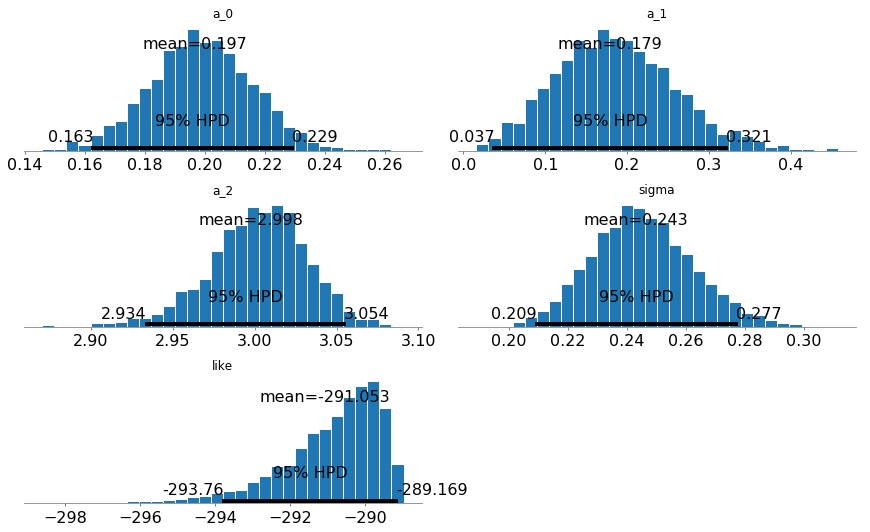

In [7]:
pm.plot_posterior(trace)

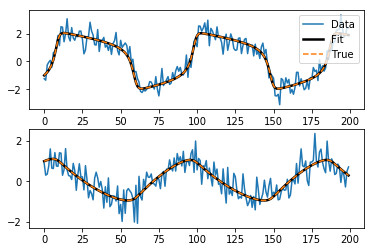

In [29]:
summary=pm.df_summary(trace, ['a'])
params=summary['mean']

est_sol=model_sol([params['a__0'],params['a__1'],params['a__2']])
plt.subplot(2,1,1)
plt.plot(Y[:,0],label='Data')
plt.plot(est_sol[:,0],color='k',linewidth=2.5,label='Fit')
plt.plot(sol[:,0],linestyle='--',label='True')
plt.legend(loc='upper right',fontsize='10')

plt.subplot(2,1,2)
plt.plot(Y[:,1])
plt.plot(est_sol[:,1],color='k',linewidth=2.5)
plt.plot(sol[:,1],linestyle='--')


In [40]:
pm.compare([trace,trace],[basic_model,basic_model])

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
0,572.73,3.85,0,0.5,29.11,0,1
1,572.73,3.85,0,0.5,29.11,0,1


In [41]:
trace

<MultiTrace: 1 chains, 10000 iterations, 3 variables>